## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch, torch.nn as nn
import torch.nn.functional as F
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from torch.autograd import Variable
from matplotlib import pyplot as plt
from pprint import pprint 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
lines = text[TEXT_START : TEXT_END]
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
all_text = ""
for sub_text in text:
    all_text += sub_text
    
text = all_text.lower()
lines = [line.lower() for line in lines]

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

In [6]:
print(tokens)

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: index for index, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index: token for index, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [107]:
def word_from_tokens(tokens):
    return np.array([token_to_idx[token] for token in tokens])

def sentectence_to_tokens(batch):
    return np.concatenate(list(map(word_from_tokens, batch)))

def shape_text(text, max_tokens_len):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

def to_matrix(text, max_len=None, dtype: str='int32', batch_first=True):
    size = max_len or max(map(len, text))
    matrix = np.zeros([len(text), size], dtype)
    for i in range(len(text)):
        line_ix = sentectence_to_tokens([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first:
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [8]:
# Your code here
class VanillaCharRNN(nn.Module):
   
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=128):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
    
def rnn_epoch(model, hidden_state, all_batches, batch_size):
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss()
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        hidden_state, out = model(batch_ix, hidden_state)
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

    epoch_loss /= n_batches
    return hidden_state, epoch_loss



In [108]:
def train(model, n_epochs, optimizer=None, max_tokens_len=10, batch_size=10):
    losses = []
    shaped_text = shape_text(text, max_tokens_len)
    all_batches = to_matrix(shaped_text, max_tokens_len)
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-th epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

In [ ]:
%%time
model = VanillaCharRNN()
optimizer = torch.optim.Adam(model.parameters())
vanilla_losses, vanilla_state = train(model, 100, optimizer)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [29]:
# Your plot code here
def plot_loss(losses: list, title: str=None):
    fig = plt.figure(figsize=(15, 10))
    if title is not None:
        plt.title(title)
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.show()

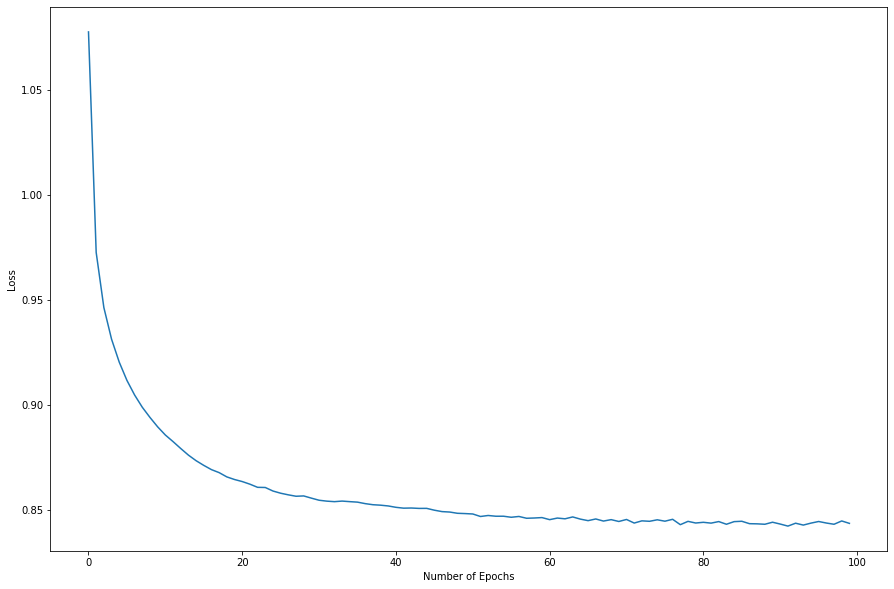

In [30]:
plot_loss(vanilla_losses)

In [48]:


def generate_sample(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        string = ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])
        final_string = ""
        for index, char in enumerate(string[:-1]):
            if char == " ":
                if string[index + 1] == " ":
                    final_string += " "
            else:
                final_string += char
    return final_string

In [110]:
print(text[:1000])

  from fairest creatures we desire increase,
  that thereby beauty's rose might never die,
  but as the riper should by time decease,
  his tender heir might bear his memory:
  but thou, contracted to thine own bright eyes,
  feed'st thy light's flame with self-substantial fuel,
  making a famine where abundance lies,
  thy self thy foe, to thy sweet self too cruel:
  thou that art now the world's fresh ornament,
  and only herald to the gaudy spring,
  within thine own bud buriest thy content,
  and tender churl mak'st waste in niggarding:
    pity the world, or else this glutton be,
    to eat the world's due, by the grave and thee.

  ii

  when forty winters shall besiege thy brow,
  and dig deep trenches in thy beauty's field,
  thy youth's proud livery so gazed on now,
  will be a tatter'd weed of small worth held:
  then being asked, where all thy beauty lies,
  where all the treasure of thy lusty days;
  to say, within thine own deep sunken eyes,
  were an all-eating shame, and

In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


In [62]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(model, seed_phrase="cupid", temperature=t, max_length=500))


	Temperature: 0.1
cupid  hearthe  be  and  the  fall  the  the  lies  and  the  be  the  live  that  the  fair  the  live  the  here  the  lies  and  the  beauty  fair  the  be  and  the  be  the  fair  the  be  the  be  i  be  with  the  be  and  the  be  and  the  be  the  love  and  the  beauty  stre  be  i  be  the  love  an

	Temperature: 0.2
cupid  in  that  this  be  be  be  beauty  and  and  the  hat  thee  be  beauty  and  the  the  the  the  fair  beauty  the  be  and  the  of  the  the  with  the  be  and  the  be  a  make  are  thee  the  hearthe  the  for  fall  here,
    the  love  love  be  be  beauty  the  best  my  stars  and  my  love

	Temperature: 0.5
cupid--
    here  stith  for  such  sweet  i  in  thee  live  self  less  that  so  self  thee,
    thy  love  but  might  beavent  this  here,
    and  for's  do  the  lie,
    and  seed  but  my  be  ou  be  see  i  bespus  not  n  my  spose  best  my  pries  i  the  sight,
        that  so  blis  cries,
    

	Temp

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [76]:
class LSTMCharRNN(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=128):
        super(LSTMCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states=None):
        x_emb = self.embedding(x)
        if states is None:
            states = initial_state(1)
        out, states = self.lstm(x_emb, states)
        
        logits = self.linear(out)
        return states, logits
    
    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True))

In [77]:
def rnn_epoch_lstm(model, states, all_batches, batch_size):
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss()
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        states, out = model(batch_ix, states)
        hidden_state, cell_state = states
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += batch_loss.item()

        hidden_state.detach_()
        hidden_state = hidden_state.detach()

        cell_state.detach_()
        cell_state = cell_state.detach()

        states = hidden_state, cell_state
        
    epoch_loss /= n_batches
    return states, epoch_loss

In [109]:
def train_lstm(model, n_epochs, optimizer=None, max_tokens_len=10, batch_size=10):
    losses = []
    shaped_text = shape_text(text, max_tokens_len)
    all_batches = to_matrix(shaped_text, max_tokens_len)
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-th epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch_lstm(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

In [ ]:
lstm_model = LSTMCharRNN()
optimizer = torch.optim.Adam(lstm_model.parameters())

lstm_losses, lstm_states = train_lstm(lstm_model, 100, optimizer)


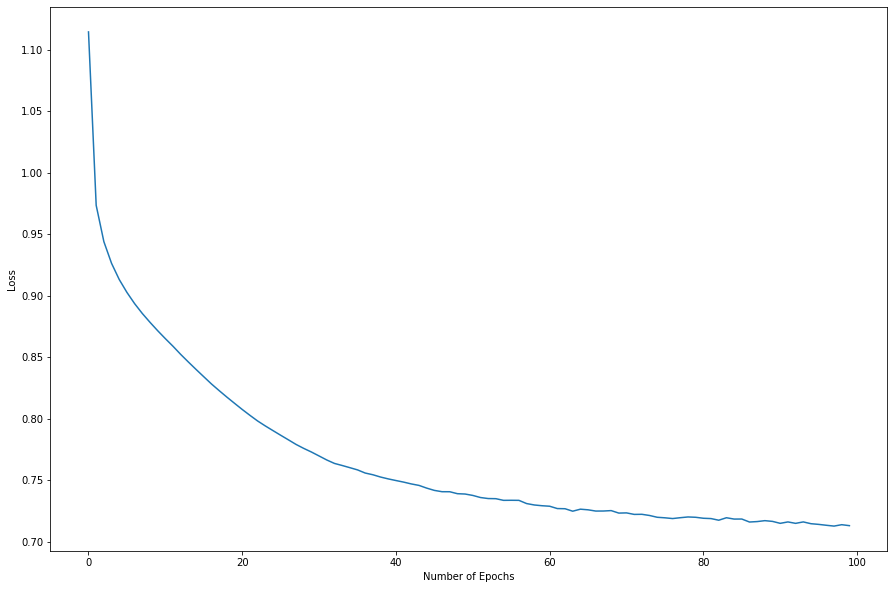

In [80]:
plot_loss(lstm_losses)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [105]:
# Text generation with different temperature values here
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(lstm_model, seed_phrase="virgin", temperature=t, max_length=500))


	Temperature: 0.1
virginsthy  seek  so  grace
    what  heart  fair  world  in  my  so  power  the  thy  heare  our  sweet  fair  st  the  the  thou  the  the  the  the  the  thou  the  the  the  for  my  my  strest  the  the  thou  the  the  the  the  the  thou  the  the  the  the  the  thou  the  the  the  the  the  thou  th

	Temperature: 0.2
virginsthy  spor'st  my  my  love
    and  be  thee  leare-foul  beare  i  be  not  fair,
    and  bod;
    thy  strais  my  form'd  for  my  self  the  thy  heare  our  se  bad  hath  me  love  i  love,
    the  the  the  fart  the  the  thy  heare  have  straise,  faire  the  for  my  love,  and  i  so  st

	Temperature: 0.5
virginsthy  swear  from      that  thy  heavent  i  thy  heruth  corn,
    and  and  i  have  i  batine,  bose  have  bare  bastrand  my  self,  theeng  this  my  beauty  me  ring  the  the  frieies  dothis  my  say  stal  be?
    and  bounderve?
    cruess
    and  be  with  not  for  my  ster  shald  la

	Temperature: 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [106]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'lstm_sonnet.pth')
new_lstm_model = LSTMCharRNN()
new_lstm_model.load_state_dict(torch.load('lstm_sonnet.pth'))
new_lstm_model.eval()

LSTMCharRNN(
  (embedding): Embedding(38, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=38, bias=True)
)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)